# Predicción Precios Argentina - MD 2022

Notebook para la competencias de [Kaggle](https://www.kaggle.com/competitions/fcen-md-2022-prediccion-precio-de-propiedades/leaderboard) de la materia MD de la maestria de DM de la UBA.

Autor: Tomás Delvechio

## Configuración de la notebook

A continuación se definen configuraciones que afectaran el resto del notebook.

In [4]:
# Libs estandar de pythons, utiles en todo el notebook
import os.path
from shutil import which
import sys

# Libs de data science
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import sklearn as sk
from sklearn import model_selection
from sklearn import ensemble
from sklearn import metrics

# No tocar
EJECUTA_COLAB = 'google.colab' in sys.modules
ESTA_KAGGLE = not EJECUTA_COLAB \
    and which("kaggle") is not None \
    and os.path.exists(os.path.join(os.getenv("HOME"), ".kaggle/kaggle.json"))
ENTORNO_DESARROLLO = "Desarrollo"
ENTORNO_PRUEBA = "Prueba"
ENTORNO_PRODUCCION = "Produccion"

## Configuraciones editables

Estas variables pueden ser editadas para cambiar comportamientos del notebook

In [5]:
# Editar para cambiar comportamiento
ENTORNO = ENTORNO_PRUEBA
ELIMINAR_COLS_CON_NAN_PROPORCION = 0.49


## Datasets

Se listan todos los datasets a considerar a continuación en un dict

In [63]:
datasets = {

    "input": {

        # Dataset de entrenamiento
        "entrenamiento": {
            "nombre": "properati_ar",
            "archivo": 'ar_properties.csv',
            "archivo_comprimido": "ar_properties.csv.gz",
            "comprimido": "gz",
            "url": "https://storage.googleapis.com/properati-data-public/ar_properties.csv.gz",
        },

        # Dataset de prueba
        "prueba": {
            "nombre": "testing",
            "archivo": "a_predecir.csv",
            "archivo_comprimido": "a_predecir.csv.zip",
            "comprimido": "zip",
            "url": "http://tomasdelvechio.github.io/subjects/dm/a_predecir.csv.zip",
        },

    },

    "output": {

        # Dataset de la fase de Limpieza inicial
        "dataset_limpio": {
            "nombre": "dataset_limpio",
            "archivo": "dataset_limpio.csv",
            "comprimido": False,
            "url": None,
        },

        # Dataset para subir a Kaggle
        "solucion": {
            "nombre": "soluciones",
            "archivo": "solucion.csv",
            "comprimido": False,
            "url": None,
        },

    },

}

### Descarga de los datasets

Controla si los datasets estan o no descargado, en caso de no estarlo, los descarga y descomprime

In [7]:
if EJECUTA_COLAB:
    DOWNLOAD_PATH = '/content'
else:
    DOWNLOAD_PATH = '.data/'
    # tratamos de crear el dir por si es la 1era vez que ejecuta
    ! mkdir -p $DOWNLOAD_PATH

for tipo, ds in datasets["input"].items():
    print(f"Procesando ds para {tipo}: {ds['nombre']}")

    fulllpath = os.path.join(
        DOWNLOAD_PATH, f"{ds['archivo_comprimido']}")
    fulllpath_raw = os.path.join(
        DOWNLOAD_PATH, ds["archivo"])

    if os.path.exists(fulllpath_raw):
        # skip download
        print(f"Dataset {ds['nombre']} descargado... No se descarga...")
    else:
        url = ds["url"]
        print(f"Descargando {ds['nombre']} desde {url}")
        ! wget -N -O $fulllpath -q $url
        if ds["comprimido"] == "gz":
            ! gzip -d -f $fulllpath
        elif ds["comprimido"] == "zip":
            ! unzip -n $fulllpath -d ".data/"
            ! rm $fulllpath

archivo_entrenamiento = os.path.join(
    DOWNLOAD_PATH, datasets["input"]["entrenamiento"]["archivo"])
archivo_prueba = os.path.join(
    DOWNLOAD_PATH, datasets["input"]["prueba"]["archivo"])


Procesando ds para entrenamiento: properati_ar
Dataset properati_ar descargado... No se descarga...
Procesando ds para prueba: testing
Dataset testing descargado... No se descarga...


Preparamos el archivo de salida

In [64]:
archivo_limpieza_inicial = os.path.join(
    DOWNLOAD_PATH, datasets["output"]["dataset_limpio"]["archivo"])
archivo_salida = os.path.join(
    DOWNLOAD_PATH, datasets["output"]["solucion"]["archivo"])

print(f"Archivo intermedio de limpieza inicial: {archivo_limpieza_inicial}")
print(f"Archivo de soluciones: {archivo_salida}")


Archivo intermedio de limpieza inicial: .data/dataset_limpio.csv
Archivo de soluciones: .data/solucion.csv


### Lectura de datos

Se levantan los df de prueba y entrenamiento. No se levantan con el índice `index_col="id"` dado que la [página de properati](https://www.properati.com.ar/data) aclara que podria no ser único.

In [9]:
df_entrenamiento_inicial = pd.read_csv(archivo_entrenamiento)#, index_col="id")
df_prueba_inicial = pd.read_csv(archivo_prueba)#, index_col="id")

if (ENTORNO == ENTORNO_DESARROLLO):
    # filtro para pruebas rápidas
    df_entrenamiento_inicial = df_entrenamiento_inicial.loc[(df_entrenamiento_inicial.l2 == "Córdoba") & (
        df_entrenamiento_inicial.operation_type == 'Venta') & (df_entrenamiento_inicial.property_type == 'Casa')]
    df_entrenamiento_inicial.shape

assert df_entrenamiento_inicial.shape[1] == 25, "El ds de entrenamiento no tiene 25 atributos. Revisar."
assert df_prueba_inicial.shape[1] == 28, "El ds de prueba no tiene 28 atributos. Revisar."
assert len(df_entrenamiento_inicial) == 1000000, "El dataset no levantó el millon de registros."


# Limpieza inicial

La idea de esta sección es una exploración gruesa de los datos, revisar que filtrado se puede hacer, que hacer con registros NaNs presentes en columnas importantes.

In [36]:
def ver_columnas(df, preffix='', suffix=''):
    print(preffix, df.columns, suffix)

ver_columnas(df_entrenamiento_inicial, "Entrenamiento:")
ver_columnas(df_prueba_inicial, "Prueba:")


Entrenamiento: Index(['id', 'ad_type', 'start_date', 'end_date', 'created_on', 'lat', 'lon',
       'l1', 'l2', 'l3', 'l4', 'l5', 'l6', 'rooms', 'bedrooms', 'bathrooms',
       'surface_total', 'surface_covered', 'price', 'currency', 'price_period',
       'title', 'description', 'property_type', 'operation_type'],
      dtype='object') 
Prueba: Index(['id', 'ad_type', 'start_date', 'end_date', 'created_on', 'lat', 'lon',
       'l1', 'l2', 'l3', 'rooms', 'bedrooms', 'bathrooms', 'surface_total',
       'surface_covered', 'price', 'currency', 'price_period', 'title',
       'description', 'property_type', 'operation_type', 'details',
       'additionals', 'services', 'l4', 'l5', 'l6'],
      dtype='object') 


¿Cuantos registros tiene cada uno de los datasets?

In [42]:
print(f"Cantidad de registros de Entrenamiento: {len(df_entrenamiento_inicial)}")
print(f"Cantidad de registros de Prueba: {len(df_prueba_inicial)}")


Cantidad de registros de Entrenamiento: 1000000
Cantidad de registros de Prueba: 1087


Se explora la columna objetivo `price`.

..:: Tipo de DF: entrenamiento ::..
Tipo de dato de columna price: float64
Cantidad de NaNs en col price: 41757 (4.1757%)
Cantidad de registros con valor Cero en price: 2900 (0.29%)
..:: Tipo de DF: Prueba ::..
Tipo de dato de columna price: float64
Cantidad de NaNs en col price: 1087 (100.0%)
Cantidad de registros con valor Cero en price: 0 (0.0%)


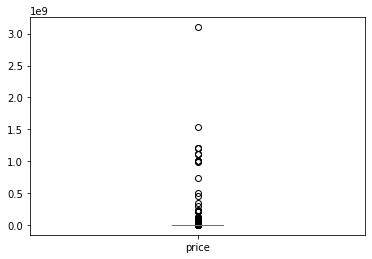

In [48]:
def exploracion_precio(df, tipo_df="entrenamiento", plot=True):
    print(f"..:: Tipo de DF: {tipo_df} ::..")
    print(f"Tipo de dato de columna price: {df.price.dtype}")

    nans_en_price_col = df.price.isna().sum()
    print(
        f"Cantidad de NaNs en col price: {nans_en_price_col} ({nans_en_price_col*100/len(df)}%)")

    cantidad_ceros_en_price_col = df.price[df.price == 0].count()
    print(
        f"Cantidad de registros con valor Cero en price: {cantidad_ceros_en_price_col} ({cantidad_ceros_en_price_col*100/len(df)}%)")

    if plot:
        df.price.plot.box();


exploracion_precio(df_entrenamiento_inicial)
exploracion_precio(df_prueba_inicial, tipo_df="Prueba", plot=False)


Se observa que la columna `price` es de tipo real y que la misma contiene mas de 40 mil registros `NaNs` y casi 3 mil en cero para el dataset de entrenamiento. En el caso de pruebas, obviamente estos valores son todos NaNs.

Se analiza ademas la columna `currency`.

..:: Tipo de DF: entrenamiento ::..
object
44509
2752  currency en nan pero que tienen un precio
Monedas NO peso ni dolar= 3080
Monedas NO peso ni dolar (%)= 0.308
Argentina         2735
Uruguay             14
Estados Unidos       3
Name: l1, dtype: int64


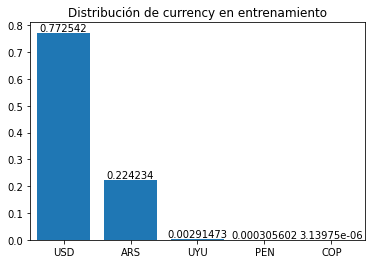

..:: Tipo de DF: Prueba ::..
object
0
0  currency en nan pero que tienen un precio
Monedas NO peso ni dolar= 0
Monedas NO peso ni dolar (%)= 0.0
Series([], Name: l1, dtype: int64)


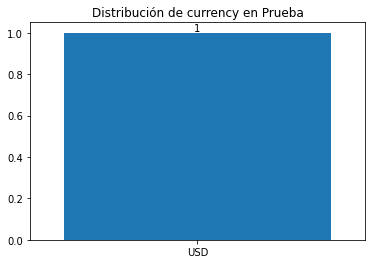

In [53]:
def analisis_columna_currency(df, tipo_df="entrenamiento"):
    print(f"..:: Tipo de DF: {tipo_df} ::..")

    print(df.currency.dtype)
    print(df.currency.isna().sum())
    relative_freq_currency_table = df.currency.value_counts(
        normalize=True, )

    df[df.currency.isna(
    )]['price'].isna().sum() == df.price.isna().sum()
    #for currency_name, currency_rel_freq in df.currency.value_counts(normalize=True, ).items():
    #    df[df.currency == currency_name].value_counts()

    print(df[(df.currency.isna(
    )) & ~(df.price.isna())]["price"].count(), " currency en nan pero que tienen un precio")

    print('Monedas NO peso ni dolar=', df.currency.isin(['UYU', 'PEN', 'COP']).sum())
    print('Monedas NO peso ni dolar (%)=',
        df.currency.isin(['UYU', 'PEN', 'COP']).sum()*100 / len(df))
    
    print(df[(df.currency.isna()) & ~(df.price.isna())]["l1"].value_counts())
    
    ax = relative_freq_currency_table.plot.bar(rot=0, title=f"Distribución de currency en {tipo_df}")
    ax.bar_label(ax.bar(
        relative_freq_currency_table.index, relative_freq_currency_table.values.tolist()))
    plt.show()


analisis_columna_currency(df_entrenamiento_inicial)
analisis_columna_currency(df_prueba_inicial, tipo_df="Prueba")


Del análisis anterior para entrenamiento, se puede observar lo siguiente:

 * La mayoria de los registros estan o bien en pesos (~22%) o dolares (~77%).
 * El restante (menos del 0.4%) son otras monedas (cerca de 3 mil registros).
 * Existen ~41 mil registros que no tienen precio
 * Estos mismos coinciden con que no tienen tampoco la `currency`.
 * Existen 2752 que tienen `price` pero sin `currency`.
 * De estos, 2735 son de Argentina, 14 de Uruguay y 3 de USA (se podria imputar `ARS`, `UYU` y `USD` respectivamente).

Para pruebas, la cuestión se reduce a que estan presentes el tipo de currency (USD).

A continuación, se analizan los tipos de propiedades presentes en el dataset, es decir, la columna `property_type`.

Venta                750831
Alquiler             207490
Alquiler temporal     41679
Name: operation_type, dtype: int64


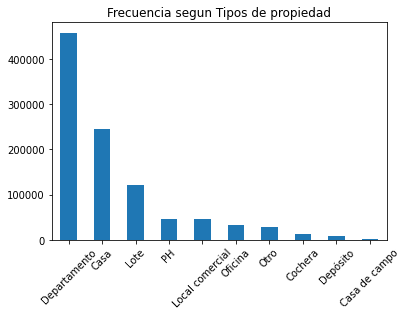

Venta    1087
Name: operation_type, dtype: int64


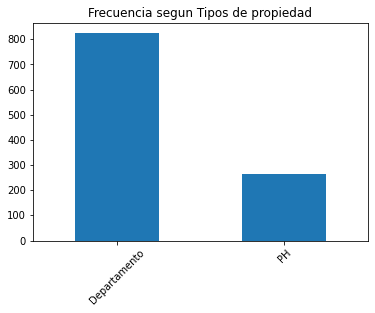

In [56]:
def analisis_operaciones_propiedades(df, tipo_df="entrenamiento"):
    print(df.operation_type.value_counts())
    _ = df.property_type.value_counts().plot.bar(rot=45, title="Frecuencia segun Tipos de propiedad")
    plt.show()

analisis_operaciones_propiedades(df_entrenamiento_inicial)
analisis_operaciones_propiedades(df_prueba_inicial)


Para el caso de entrenamiento:
- A partir de lo anterior, tenemos entonces una preminencia de propiedades de tipo Deptos, casas y lotes.
- Por el lado del tipo de operación, el tipo `Venta` representa prácticamente el 75% de las observaciones.

Para pruebas:
- Se observa que son solo operaciones de venta
- Lo unico presente en el dataset son Deptos y PHs

Analizamos la distribución por Pais:

In [59]:
print(df_entrenamiento_inicial.l1.value_counts())
print(df_prueba_inicial.l1.value_counts())


Argentina         983115
Uruguay            15749
Estados Unidos       892
Brasil               244
Name: l1, dtype: int64
Argentina    1087
Name: l1, dtype: int64


Interesa particularmente ver cuantas publicaciones existen para Argentina, en dolares, en el df de entrenamiento:

In [60]:
print(df_entrenamiento_inicial.currency[df_entrenamiento_inicial.l1 == "Argentina"].value_counts())


USD    724879
ARS    214114
PEN       292
COP         3
Name: currency, dtype: int64


Observamos entonces que existen aprox un ~72% de publicaciones que son de Argentina en dolares.

## Generación de dataset limpio

Para organizar el código, acá se definen una serie de reglas de limpieza inicial, Que se guardaran para su uso en las etapas siguientes sin tener que re-ejecutar todo estos pasos nuevamente.

**Definiciones del dataset**

- Se conservan solo filas con currency en dolares.
- Se conservan filas que solo sean de argentina.
- Se conservan solo las operaciones de venta.
- Se mantienen en el df aquellas propiedades de tipo Departamentos y PH.

In [62]:
print(len(df_entrenamiento_inicial))
df_entrenamiento_limpio = df_entrenamiento_inicial[df_entrenamiento_inicial.currency == 'USD']
print(len(df_entrenamiento_limpio))
df_entrenamiento_limpio = df_entrenamiento_limpio[df_entrenamiento_limpio.l1 == 'Argentina']
print(len(df_entrenamiento_limpio))
df_entrenamiento_limpio = df_entrenamiento_limpio[df_entrenamiento_limpio.operation_type == 'Venta']
print(len(df_entrenamiento_limpio))
df_entrenamiento_limpio = df_entrenamiento_limpio[df_entrenamiento_limpio.property_type.isin(['Departamento', 'PH'])]
print(len(df_entrenamiento_limpio))


1000000
738157
724879
686272
334462


Con este filtrado nos quedamos con el 33% del dataset.

In [65]:
df_entrenamiento_limpio.to_csv(archivo_limpieza_inicial, index=False)


# Análisis del conjunto de datos

Se analizan ambos datasets para conocerlos y caracterizarlos.

El nuevo dataset de entrenamiento es el limpio.


In [66]:
df_entrenamiento_inicial = pd.read_csv(archivo_limpieza_inicial)


In [67]:
df_entrenamiento_inicial.head()

,id,ad_type,start_date,end_date,created_on,lat,lon,l1,l2,l3,...,bathrooms,surface_total,surface_covered,price,currency,price_period,title,description,property_type,operation_type
0,U3qdJMKXnOJm0Y1tWpnnfg==,Propiedad,2020-08-22,2020-09-04,2020-08-22,-34.597364,-58.372987,Argentina,Capital Federal,Retiro,...,NaN,NaN,25.0,85000.0,USD,Mensual,Departamento - Capital Federal,"EXCELENTE DEPTO MUY LUMINOSO, <br><br>LAS MEDI...",Departamento,Venta
1,gsQB/JzLxaQdBLfNcm/DMw==,Propiedad,2020-08-22,2020-09-04,2020-08-22,-34.600004,-58.417191,Argentina,Capital Federal,Almagro,...,1.0,38.0,31.0,110000.0,USD,Mensual,Monoambiente c/Cochera Fija Cubierta. Edif c/P...,Monoambiente de 38m² en muy buen estado con Am...,Departamento,Venta
2,SlPt6GJRjM+cO4rD3n3HFQ==,Propiedad,2020-08-22,2020-09-04,2020-08-22,-34.581699,-58.433547,Argentina,Capital Federal,Palermo,...,1.0,35.0,30.0,105000.0,USD,Mensual,Oportunidad!!!!Palermo Hollywood Monoamb amobl...,RETASADO Venta Palermo Niceto Vega y Bonpland ...,Departamento,Venta
3,ZaH+6DXJ4MLM6QqZXhgWiw==,Propiedad,2020-08-22,2020-09-04,2020-08-22,-34.595044,-58.442538,Argentina,Capital Federal,Palermo,...,1.0,51.0,46.0,150000.0,USD,Mensual,2 AMBIENTES CON COCHERA Y PARRILLA EN VILLA CR...,CONTACTO: 11- (LLAMADOS O WHATSAPP)<br><br>EXC...,Departamento,Venta
4,r7qrM5xaYo8QImSnqyKyYA==,Propiedad,2020-08-22,2020-09-04,2020-08-22,-34.582549,-58.417350,Argentina,Capital Federal,Palermo,...,1.0,53.0,53.0,136500.0,USD,Mensual,2 AMB EN PALERMO,2 AMBIENTES CON 2 BALCÓNES PISO 8<br><br>Inmej...,Departamento,Venta


Se observan 24 columnas con datos de diversa indole.

Las columnas son:

In [68]:
df_entrenamiento_inicial.dtypes

id                  object
ad_type             object
start_date          object
end_date            object
created_on          object
lat                float64
lon                float64
l1                  object
l2                  object
l3                  object
l4                  object
l5                  object
l6                 float64
rooms              float64
bedrooms           float64
bathrooms          float64
surface_total      float64
surface_covered    float64
price              float64
currency            object
price_period        object
title               object
description         object
property_type       object
operation_type      object
dtype: object

En principio hay preeminencia de columnas no numéricas.

In [69]:
df_entrenamiento_inicial.dtypes.value_counts()

object     16
float64     9
dtype: int64

In [70]:
df_entrenamiento_inicial.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334462 entries, 0 to 334461
Data columns (total 25 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               334462 non-null  object 
 1   ad_type          334462 non-null  object 
 2   start_date       334462 non-null  object 
 3   end_date         334462 non-null  object 
 4   created_on       334462 non-null  object 
 5   lat              309275 non-null  float64
 6   lon              309250 non-null  float64
 7   l1               334462 non-null  object 
 8   l2               334462 non-null  object 
 9   l3               329298 non-null  object 
 10  l4               88031 non-null   object 
 11  l5               683 non-null     object 
 12  l6               0 non-null       float64
 13  rooms            310881 non-null  float64
 14  bedrooms         271479 non-null  float64
 15  bathrooms        311829 non-null  float64
 16  surface_total    174747 non-null  floa

Vamos a describir a continuación cada columna. El Id no se lista pero es la columna 25. No es el index del dataframe.

| # | Columna | Descripción |
|---|---------|-------------|
| 1 | ad_type   | Tipo de publicación o aviso |
|---|---------|-------------|
| 2 | start_date    | Fecha de alta |
| 3 | end_date  | Fecha de baja |
| 4 | created_on    | Fecha de alta de la primer versión |
|---|---------|-------------|
| 5 | lat   | Latitud |
| 6 | lon   | Longitud |
| 7 | l1    | País |
| 8 | l2    | Provincia |
| 9 | l3    | Ciudad |
| 10 | l4    | Barrio |
| 11 | l5    | ??? |
| 12 | l6    | ??? |
|---|---------|-------------|
| 13 | rooms | Cantidad de ambientes |
| 14 | bedrooms  | Cantidad de dormitorios |
| 15 | bathrooms | Cantidad de baños |
| 16 | surface_total | Superficie en m² |
| 17 | surface_covered   | Superficie cubierta en m² |
| 18 | price | Precio publicado |
| 19 | currency  | Moneda del precio |
| 20 | price_period  | si el precio es diario, semanal, mensual |
| 21 | title | título del anuncio |
| 22 | description   | descripcion del anuncio |
| 23 | property_type | Si es casa, depto, PH... |
| 24 | operation_type    | Si es venta, alquiler... |

Agrupamos los diferentes conceptos del dataset por columnas relacionadas:

In [75]:
columnas_id = ["id", "ad_type", ]
columnas_fecha = ["start_date", "end_date", "created_on", ]
columnas_ubicacion = [
    "lat",
    "lon",
    "l1",
    "l2",
    "l3",
    "l4",
    "l5",
    "l6",
]
columnas_publicacion = [
    "rooms",
    "bedrooms",
    "bathrooms",
    "surface_total",
    "surface_covered",
    "price",
    "currency",
    "price_period",
    "title",
    "description",
    "property_type",
    "operation_type",
]


## Estudio de columnas de ubicación

A continuación se estudian los valores relacionados a las columnas de ubicación

In [76]:
print(df_entrenamiento_inicial[columnas_ubicacion].head())
df_entrenamiento_inicial[columnas_ubicacion].tail()


         lat        lon         l1                            l2  \
0 -34.407468 -58.957367  Argentina      Bs.As. G.B.A. Zona Norte   
1 -37.996039 -57.542509  Argentina  Buenos Aires Costa Atlántica   
2 -31.380187 -58.009182  Argentina                    Entre Ríos   
3 -27.494106 -55.123455  Argentina                      Misiones   
4 -32.948856 -60.630464  Argentina                      Santa Fe   

              l3   l4   l5  l6  
0          Pilar  NaN  NaN NaN  
1  Mar del Plata  NaN  NaN NaN  
2      Concordia  NaN  NaN NaN  
3          Oberá  NaN  NaN NaN  
4        Rosario  NaN  NaN NaN  


,lat,lon,l1,l2,l3,l4,l5,l6
999995,-32.958863,-60.665633,Argentina,Santa Fe,Rosario,NaN,NaN,NaN
999996,-34.596587,-58.376893,Argentina,Capital Federal,Retiro,NaN,NaN,NaN
999997,-34.576445,-58.432603,Argentina,Capital Federal,Palermo,NaN,NaN,NaN
999998,-32.866636,-68.841144,Argentina,Mendoza,NaN,NaN,NaN,NaN
999999,-34.447524,-58.631552,Argentina,Bs.As. G.B.A. Zona Norte,Tigre,Santa Barbara Barrio Cerrado,NaN,NaN


In [77]:
print("Colname - % de nulls")
df_entrenamiento_inicial[columnas_ubicacion].isna(
).sum() / len(df_entrenamiento_inicial)


Colname - % de nulls


lat    0.105767
lon    0.105809
l1     0.000000
l2     0.000000
l3     0.034727
l4     0.693838
l5     0.994470
l6     1.000000
dtype: float64

Al parecer l5 es candidata a desaparecer y l6 será eliminada seguramente.

Miraremos a continuación la distribución de las columnas númericas.

<AxesSubplot:>

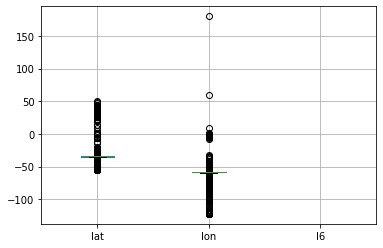

In [78]:
df_entrenamiento_inicial[columnas_ubicacion].boxplot()


## Estudio de columnas de fechas

A continuación se estudian los valores relacionados a las columnas de fechas

In [79]:
df_entrenamiento_inicial[columnas_fecha].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 3 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   start_date  1000000 non-null  object
 1   end_date    1000000 non-null  object
 2   created_on  1000000 non-null  object
dtypes: object(3)
memory usage: 22.9+ MB


Son columnas strings, no datetime

In [80]:
df_entrenamiento_inicial[columnas_fecha].head()


,start_date,end_date,created_on
0,2020-08-22,2020-09-03,2020-08-22
1,2020-08-22,2020-09-04,2020-08-22
2,2020-08-22,2020-08-31,2020-08-22
3,2020-08-22,2020-09-04,2020-08-22
4,2020-08-22,2020-09-04,2020-08-22


In [81]:
df_entrenamiento_inicial[columnas_fecha].describe()


,start_date,end_date,created_on
count,1000000,1000000,1000000
unique,362,450,362
top,2020-10-02,9999-12-31,2020-10-02
freq,25159,208960,25159


<AxesSubplot:xlabel='start_date,end_date,created_on'>

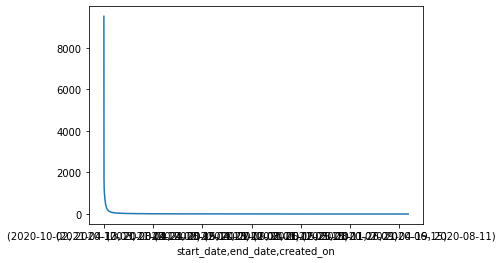

In [82]:
df_entrenamiento_inicial[columnas_fecha].value_counts().plot()
#df_entrenamiento_inicial[columnas_fecha].value_counts()[:5].plot()


Se puede observar que las combinaciones de fechas siguen un patron de "Ley de Potencias".

¿Que pasa con cada columna individual?

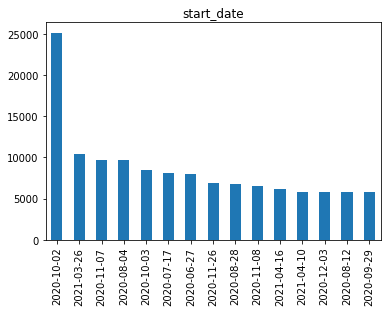

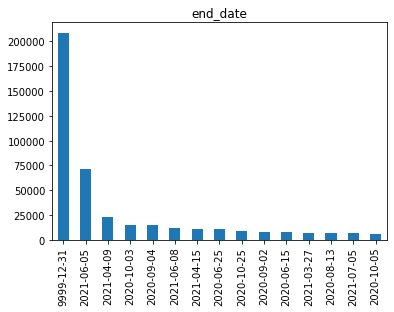

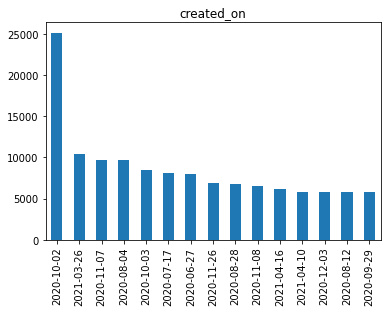

In [83]:
for columna in columnas_fecha:
    df_entrenamiento_inicial[columna].value_counts()[:15].plot(kind='bar')
    plt.title(columna)
    plt.show()


La columna `end_date` se usa bastante mal. El valor con mayor frecuencia es `9999-12-31`. El mismo aparece mas del 20 % de las veces.

Por otro lado, parece que las columnas `start_date` y `created_on` son iguales.

In [84]:
assert (df_entrenamiento_inicial.start_date ==
        df_entrenamiento_inicial.created_on).sum() == len(df_entrenamiento_inicial), \
        "El ds de entrenamiento tiene diferencias entre columnas start_date y created_on"


## Estudio de columnas de publicación

Las columnas de publicación son aquellas que refieren a información de la propiedad publicada.

In [85]:
df_entrenamiento_inicial[columnas_publicacion].describe(include=object)

,currency,price_period,title,description,property_type,operation_type
count,955491,429870,999999,999958,1000000,1000000
unique,5,3,548833,817449,10,3
top,USD,Mensual,casa-venta,Departamento en Alquiler de 1 dorm. en Cordoba,Departamento,Venta
freq,738157,429842,3338,1980,457907,750831


In [86]:
df_entrenamiento_inicial[columnas_publicacion].describe()


,rooms,bedrooms,bathrooms,surface_total,surface_covered,price
count,714179.000000,649933.000000,765122.000000,477831.000000,4.877560e+05,9.582430e+05
mean,2.916567,2.097815,1.708581,513.760752,1.165622e+04,3.460940e+05
std,1.739685,2.079008,1.092221,4297.241604,4.443191e+06,5.713690e+06
min,1.000000,-16.000000,1.000000,-136.000000,-1.300000e+02,0.000000e+00
25%,2.000000,1.000000,1.000000,50.000000,4.500000e+01,3.800000e+04
50%,3.000000,2.000000,1.000000,95.000000,7.800000e+01,9.700000e+04
75%,4.000000,3.000000,2.000000,250.000000,1.680000e+02,2.100000e+05
max,40.000000,900.000000,20.000000,200000.000000,2.147484e+09,3.100000e+09


In [87]:
columnas_publicacion_sin_precio = list(columnas_publicacion)
columnas_publicacion_sin_precio.remove('price')


<AxesSubplot:>

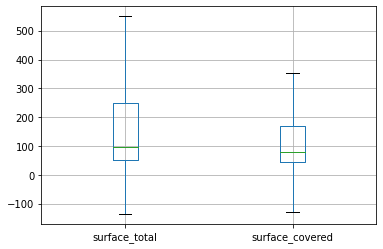

In [88]:
df_entrenamiento_inicial[['surface_total', 'surface_covered']].boxplot(
    showfliers=False)


<AxesSubplot:>

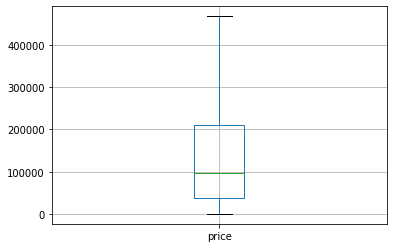

In [89]:
df_entrenamiento_inicial[['price']].boxplot(
    showfliers=False)


En cuanto a los NaNs presentes en estas columnas, se puede observar lo siguiente:

In [111]:
#print("Colname - % de nulls")
#df_entrenamiento_inicial[columnas_publicacion].isna(
#).sum() / len(df_entrenamiento_inicial)

#print("Colname - % de nulls")
prop_nans_por_columna = df_entrenamiento_inicial.isna(
).sum() / len(df_entrenamiento_inicial)
columnas_con_nans_a_descartar = list(
    prop_nans_por_columna[prop_nans_por_columna > ELIMINAR_COLS_CON_NAN_PROPORCION].index)


Se observan varios casos donde la cantidad de NaNs es mas de la mitad de las columnas

In [ ]:
df_entrenamiento_inicial.boxplot(list(df_entrenamiento_inicial.columns))


In [ ]:
# Outliers analisis
#df_entrenamiento_inicial[(np.abs(stats.zscore(df_entrenamiento_inicial)) < 3).all(axis=1)]
#np.abs(stats.zscore(df_entrenamiento_inicial)) > 3


,lat,lon,l6,rooms,bedrooms,bathrooms,surface_total,surface_covered,price


# Tratamiento de los datos

**TODO**
* Determinar método para eliminar columnas con mas de un X % de NaNs.
* Pasar cols de fechas a datetimes
* Eliminar col created_on pues es igual a start_date

In [71]:
df_entrenamiento_inicial.describe()


,lat,lon,l6,rooms,bedrooms,bathrooms,surface_total,surface_covered,price
count,309275.000000,309250.000000,0.0,310881.000000,271479.000000,311829.000000,174747.000000,1.828230e+05,3.344620e+05
mean,-34.636291,-59.035227,NaN,2.577990,1.764881,1.401262,111.522183,1.506312e+02,1.778319e+05
std,1.716539,1.978469,NaN,1.258869,1.268859,0.726301,1365.602158,2.601612e+04,3.324364e+05
min,-54.831793,-111.717740,NaN,1.000000,-1.000000,1.000000,10.000000,-2.000000e+00,0.000000e+00
25%,-34.658114,-58.576553,NaN,2.000000,1.000000,1.000000,45.000000,4.000000e+01,7.500000e+04
50%,-34.597931,-58.454216,NaN,2.000000,2.000000,1.000000,62.000000,5.500000e+01,1.155000e+05
75%,-34.547304,-58.398826,NaN,3.000000,2.000000,2.000000,95.000000,8.000000e+01,1.880000e+05
max,44.405990,-2.539603,NaN,35.000000,153.000000,19.000000,194273.000000,1.111111e+07,4.772660e+07


## Estandarización y Normalización de Datos númericos


<AxesSubplot:>

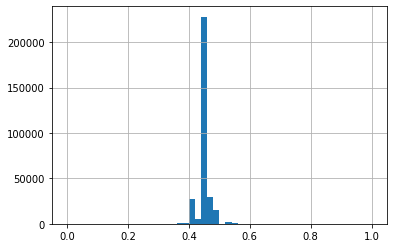

In [72]:
#df_entrenamiento_inicial.lat.hist(bins=50)

dfe_estandarizado = df_entrenamiento_inicial.select_dtypes(
    include=['float64', 'int64', 'uint8'])

# estandarización min-max
dfe_estandarizado = (dfe_estandarizado -
                     dfe_estandarizado.min()) / (dfe_estandarizado.max() - dfe_estandarizado.min())

dfe_transformado = np.sqrt(dfe_estandarizado)

#dfe_estandarizado = dfe_estandarizado
dfe_transformado.lat.hist(bins=50)


In [75]:
#df_entrenamiento_inicial.lat.describe()
dfe_transformado.columns


Index(['lat', 'lon', 'l6', 'rooms', 'bedrooms', 'bathrooms', 'surface_total',
       'surface_covered', 'price'],
      dtype='object')

In [121]:
dfe_estandarizado.lat.describe()


count    894233.000000
mean          0.195874
std           0.029059
min           0.000000
25%           0.192564
50%           0.193811
75%           0.195507
max           1.000000
Name: lat, dtype: float64

## Eliminación de columnas con baja varianza


In [74]:
df2 = dfe_transformado.select_dtypes(
    include=['float64', 'int64', 'uint8'])

varianzas_cols = {}
for c in df2.columns:
    varianzas_cols[c] = df2[c].var()

varianzas_ordenadas = dict(sorted(varianzas_cols.items(
), key=lambda item: item[1]), sort_keys=True, indent=4)
columnas_con_baja_varianza = []
for col, varianza in varianzas_ordenadas.items():
  if varianza < 1:
    columnas_con_baja_varianza.append(col)

print(columnas_con_baja_varianza)


['lon', 'surface_total', 'lat', 'surface_covered', 'bedrooms', 'price', 'rooms', 'bathrooms']


In [127]:
columnas_con_baja_varianza = []


# Modelización

In [131]:
columnas_a_modelar = set(df_entrenamiento_inicial.columns) - \
    set(columnas_con_baja_varianza) - \
    set(columnas_con_nans_a_descartar)
columnas_a_modelar = list(columnas_a_modelar)
columnas_a_modelar


['description',
 'currency',
 'l1',
 'lon',
 'operation_type',
 'created_on',
 'bedrooms',
 'l2',
 'end_date',
 'lat',
 'id',
 'l3',
 'price',
 'property_type',
 'ad_type',
 'rooms',
 'title',
 'bathrooms',
 'start_date']

In [76]:
df_entrenamiento_a_modelar = dfe_transformado


In [77]:
df_entrenamiento_a_modelar = df_entrenamiento_inicial.select_dtypes(include=[
                                                                    'float64', 'int64'])
df_entrenamiento_a_modelar.fillna(0, inplace=True, downcast="infer")

# Filtro de columnas para el df de pruebas
df_prueba = df_prueba_inicial[df_entrenamiento_a_modelar.columns].copy(
)


In [ ]:
if False:
    X = df_entrenamiento_a_modelar[df_entrenamiento_a_modelar.columns.drop('price')]
    y = df_entrenamiento_a_modelar['price']

    for n_estimators in [100, 500, 1000]:
        for max_depth in [3, 7, 11]:

            ## Tienen que usar RandomForestRegressor si o si o si. Pueden cambiar los parámetros
            reg = sk.ensemble.RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42, n_jobs=-1)

            ## Validación cruzada en 5 partes (lo van a ver en AA), -RMSE. No tocar
            scores = sk.model_selection.cross_val_score(reg, X, y, cv=10, scoring='neg_root_mean_squared_error')

            ## Imprimimos scores. Cuando más bajo mejor
            print(f"n_estimators={n_estimators}, max_depth={max_depth} --> {-scores.mean():.3f} +/- {scores.std():.3f}")


In [78]:
X = df_entrenamiento_a_modelar[df_entrenamiento_a_modelar.columns.drop('price')]
y = df_entrenamiento_a_modelar['price']


In [79]:
# version todo por 2 pesos
## Tienen que usar RandomForestRegressor si o si o si. Pueden cambiar los parámetros
reg = sk.ensemble.RandomForestRegressor(
    n_estimators=100, max_depth=7, random_state=42, n_jobs=-1)

## Validación cruzada en 5 partes (lo van a ver en AA), -RMSE. No tocar
scores = sk.model_selection.cross_val_score(
    reg, X, y, cv=10, scoring='neg_root_mean_squared_error')

## Imprimimos scores. Cuando más bajo mejor
print(f"{-scores.mean():.3f} +/- {scores.std():.3f}")


269925.840 +/- 67086.532


In [80]:
#df_pred = pd.read_csv(archivo_prueba, index_col="id")
df_prueba.fillna(0, inplace=True)

In [81]:
X_pred = df_prueba[X.columns]


In [82]:
# los mejores hiperparámetros encontrados antes
n_estimators = 100
max_depth = 7

# entrenamiento
reg = sk.ensemble.RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42, n_jobs=-1)
reg.fit(X, y)

# predicción
df_prueba["price"] = reg.predict(X_pred)


In [83]:
# grabo la solución
df_prueba.index.name = 'id'
df_prueba["id"] = df_prueba_inicial.id
df_prueba[["id", "price"]].to_csv(archivo_salida, index=False)


In [84]:
if ESTA_KAGGLE:
    ! kaggle competitions submit -c fcen-md-2022-prediccion-precio-de-propiedades -f $archivo_salida -m "Prueba enviar predicción desde Notebook"


100%|██████████████████████████████████████| 23.8k/23.8k [00:02<00:00, 8.96kB/s]
Successfully submitted to FCEN MD 2022 - Predicción precio de propiedades

In [7]:
d = {'col1': [0, 1, 2, 3], 'col2': pd.Series([2, 3], index=[2, 3])}
df = pd.DataFrame(data=d, index=[0, 1, 2, 3])
df.to_dict()

{'col1': {0: 0, 1: 1, 2: 2, 3: 3}, 'col2': {0: nan, 1: nan, 2: 2.0, 3: 3.0}}